In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("E:/sem5/apl302product/computational_project/reduced_data.csv")

In [9]:
df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31,PCA32,PCA33
0,-11.778852,-5.963981,2.708248,0.291570,-8.006616,-0.704716,-1.576061,-0.569835,1.145670,-3.903905,...,-0.192099,0.841043,-0.677818,-1.100252,1.631540,3.740700,-1.343874,-1.716328,14.952151,-1.464276
1,-8.364062,-5.211114,2.624651,2.394817,-5.990686,3.183806,2.804452,-9.446988,1.895687,-3.324126,...,0.954720,0.141486,-0.115227,-0.767748,0.063448,-0.148283,-2.423913,-0.757914,7.311984,-0.893515
2,-14.688830,0.935685,2.557508,2.727295,-4.719920,0.800718,0.966228,-4.047640,1.352594,-2.591009,...,0.107462,0.234375,-0.328368,-0.957779,0.482528,0.435835,-1.483361,0.079695,9.739580,-0.806933
3,-1.910175,-3.550928,1.806465,1.173408,-4.542943,3.716949,1.656472,-11.128732,1.854527,-3.212603,...,0.538462,-0.680553,-0.698616,-0.838881,-0.164171,-0.388981,-2.099941,-0.317198,3.593064,-2.004192
4,-4.126756,-0.388126,3.222836,-5.845613,-2.105691,0.929160,0.729523,-0.887728,0.618052,-1.056827,...,-0.314542,0.279962,-0.386722,-0.538391,1.221219,0.373537,-0.242861,0.511739,5.357347,0.095367


In [11]:
X = df.values

In [12]:
# Standardize the data
data_mean = np.mean(X, axis=0)
data_std = np.std(X, axis=0)
X = (X - data_mean) / data_std

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Hyperparameters
latent_dim = 32  # Adjusted for the dimensionality of the latent space
hidden_dim = 128
lr = 0.0002
num_epochs = 5000
batch_size = 64

In [14]:
# Convert data to torch tensors
real_data = torch.tensor(X, dtype=torch.float32).to(device)

In [15]:
# Define Generator for Tabular Data
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.model(z)

In [16]:
# Define Discriminator for Tabular Data
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [17]:
# Initialize generator and discriminator
generator = Generator(latent_dim, X.shape[1]).to(device)
discriminator = Discriminator(X.shape[1]).to(device)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

In [20]:
# Training loop
for epoch in range(num_epochs):
    # Sample real data batch
    idx = torch.randint(0, len(real_data), (batch_size,))
    real_samples = real_data[idx]
    valid = torch.ones(batch_size, 1).to(device)
    fake = torch.zeros(batch_size, 1).to(device)

    # Train Discriminator
    optimizer_D.zero_grad()
    z = torch.randn(batch_size, latent_dim).to(device)
    fake_samples = generator(z)
    real_loss = adversarial_loss(discriminator(real_samples), valid)
    fake_loss = adversarial_loss(discriminator(fake_samples.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    gen_loss = adversarial_loss(discriminator(fake_samples), valid)
    gen_loss.backward()
    optimizer_G.step()

    # Display progress
    if epoch % 500 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {gen_loss.item():.4f}")

# Generate synthetic data after training
num_samples = 100
z = torch.randn(num_samples, latent_dim).to(device)
generated_data = generator(z).detach().cpu().numpy()
generated_data = generated_data * data_std + data_mean  # Reverse normalization

# Save generated data to CSV
generated_df = pd.DataFrame(generated_data, columns=df.columns)
generated_df.to_csv('E:/sem5/apl302product/computational_project/generated_data.csv', index=False)

print("New data generated and saved as 'generated_data.csv'")

Epoch [0/5000] | D Loss: 0.6396 | G Loss: 0.7998
Epoch [500/5000] | D Loss: 0.6343 | G Loss: 0.8481
Epoch [1000/5000] | D Loss: 0.6058 | G Loss: 1.0437
Epoch [1500/5000] | D Loss: 0.6025 | G Loss: 1.0490
Epoch [2000/5000] | D Loss: 0.6397 | G Loss: 0.9784
Epoch [2500/5000] | D Loss: 0.6726 | G Loss: 0.8861
Epoch [3000/5000] | D Loss: 0.6577 | G Loss: 0.9825
Epoch [3500/5000] | D Loss: 0.7362 | G Loss: 0.7265
Epoch [4000/5000] | D Loss: 0.5730 | G Loss: 0.8983
Epoch [4500/5000] | D Loss: 0.7033 | G Loss: 0.7965
New data generated and saved as 'generated_data.csv'


In [21]:
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance, ks_2samp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
# Load real and generated data
real_data = pd.read_csv("E:/sem5/apl302product/computational_project/reduced_data.csv").values
generated_data = pd.read_csv('E:/sem5/apl302product/computational_project/generated_data.csv').values

In [23]:
# 1. Statistical Similarity: Compare distributions with Wasserstein Distance and Kolmogorov-Smirnov Test
distances = [wasserstein_distance(real_data[:, i], generated_data[:, i]) for i in range(real_data.shape[1])]
mean_wasserstein_distance = np.mean(distances)
print(f"Mean Wasserstein Distance (Lower is better): {mean_wasserstein_distance:.4f}")


Mean Wasserstein Distance (Lower is better): 0.7696


In [24]:
ks_statistics = [ks_2samp(real_data[:, i], generated_data[:, i]).statistic for i in range(real_data.shape[1])]
mean_ks_statistic = np.mean(ks_statistics)
print(f"Mean KS Statistic (Lower is better): {mean_ks_statistic:.4f}")

Mean KS Statistic (Lower is better): 0.1516


In [25]:
# For example, a binary target column
np.random.seed(0)
real_target = np.random.randint(0, 2, size=len(real_data))
generated_target = np.random.randint(0, 2, size=len(generated_data))

X_train, y_train = generated_data, generated_target
X_test, y_test = real_data, real_target

# Train classifier on synthetic data and evaluate on real data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy trained on synthetic data and tested on real data: {model_accuracy:.4f}")


Model accuracy trained on synthetic data and tested on real data: 0.5042


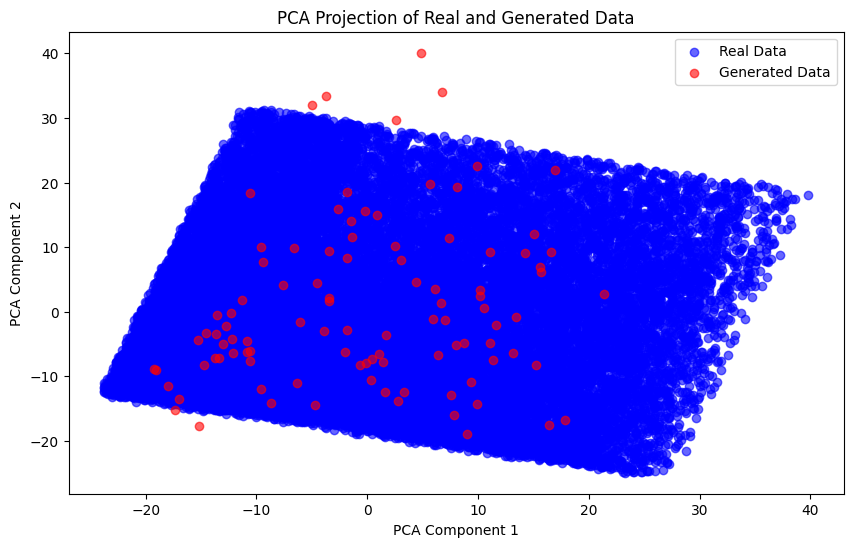

In [26]:
# 3. Dimensionality Reduction Visualization: PCA
pca = PCA(n_components=2)
real_data_pca = pca.fit_transform(real_data)
generated_data_pca = pca.transform(generated_data)

plt.figure(figsize=(10, 6))
plt.scatter(real_data_pca[:, 0], real_data_pca[:, 1], label="Real Data", alpha=0.6, c='blue')
plt.scatter(generated_data_pca[:, 0], generated_data_pca[:, 1], label="Generated Data", alpha=0.6, c='red')
plt.title("PCA Projection of Real and Generated Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [27]:
combined_data = np.vstack((real_data, generated_data))
labels = np.array([0] * len(real_data) + [1] * len(generated_data))  # Label real as 0, generated as 1
silhouette_avg = silhouette_score(combined_data, labels)
print(f"Silhouette Score for real vs generated data (Closer to 1 is better): {silhouette_avg:.4f}")

# Summary of Results
print("\nQuality Metrics Summary:")
print(f"Mean Wasserstein Distance: {mean_wasserstein_distance:.4f}")
print(f"Mean KS Statistic: {mean_ks_statistic:.4f}")
print(f"Model Accuracy: {model_accuracy:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score for real vs generated data (Closer to 1 is better): -0.0419

Quality Metrics Summary:
Mean Wasserstein Distance: 0.7696
Mean KS Statistic: 0.1516
Model Accuracy: 0.5042
Silhouette Score: -0.0419
